<a href="https://colab.research.google.com/github/h8erqqq/ML/blob/main/Econlab4_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1.Исследование системы на идентифицируемость включает проверку каждого уравнения отдельно. Для этого используется правило порядка. Правило гласит, что уравнение идентифицируемо, если количество исключенных из него экзогенных переменных (не включенных в данное уравнение, но включенных в другие уравнения системы) больше или равно разности между общим количеством эндогенных переменных минус два (общее количество эндогенных переменных, минус одна эндогенная переменная в левой части, минус одна эндогенная переменная, которая включена в данное уравнение).

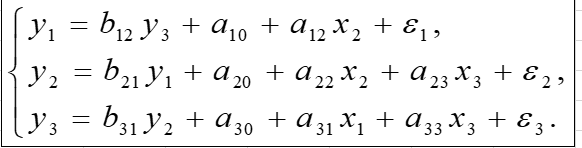

Уравнение для y1 исключает x1 и x3. Всего 3 экзогенных переменных, поэтому необходимо минимум 1 исключенная экзогенная переменная для идентифицируемости. Уравнение идентифицируемо.
Уравнение для y2 исключает x1 => тоже идентифицируемо. Аналогично уравнение для y3 исключает x2 и является идентифицируемым.

2. Выбор метода оценки параметров
Для оценки параметров модели с эндогенными и экзогенными переменными, одним из подходящих методов является двухшаговый метод наименьших квадратов (2SLS). Он особенно полезен в случаях, когда есть обратная связь между зависимыми и независимыми переменными.

In [1]:
import numpy as np
import pandas as pd

# Задаем параметры для воспроизводимости случайных чисел
np.random.seed(0)

# Генерируем данные
n = 20  # количество наблюдений
x1 = np.random.normal(0, 1, n)  # экзогенная переменная x1
x2 = np.random.normal(0, 1, n)  # экзогенная переменная x2
x3 = np.random.normal(0, 1, n)  # экзогенная переменная x3

# Создаем DataFrame для удобства
data = pd.DataFrame({'x1': x1, 'x2': x2, 'x3': x3})

data.head()  # Показываем первые несколько строк данных


,x1,x2,x3
0,1.764052,-2.552990,-1.048553
1,0.400157,0.653619,-1.420018
2,0.978738,0.864436,-1.706270
3,2.240893,-0.742165,1.950775
4,1.867558,2.269755,-0.509652


Теперь у нас есть сгенерированные данные для экзогенных и эндогенных переменных. Мы готовы приступить к оценке параметров модели с использованием двухшагового метода наименьших квадратов.

Этот метод оценки состоит из двух этапов:

Первый этап: Для каждой эндогенной переменной в правой части каждого уравнения создается вспомогательная регрессия на все экзогенные переменные в модели. Результаты этих регрессий используются для получения предсказанных значений эндогенных переменных.

Второй этап: Оригинальные уравнения оцениваются методом наименьших квадратов, но вместо фактических эндогенных переменных используются их предсказанные значения с первого этапа.

In [2]:
# Задаем произвольные коэффициенты для модели
b12, b21, b31 = 0.5, -0.3, 0.4
a10, a20, a30 = 0.1, -0.2, 0.3
a12, a22, a23, a31, a33 = 0.6, -0.5, 0.7, -0.4, 0.5

# Генерируем случайные ошибки
e1 = np.random.normal(0, 0.1, n)
e2 = np.random.normal(0, 0.1, n)
e3 = np.random.normal(0, 0.1, n)

# Последовательно генерируем значения для эндогенных переменных
# Начнем с предположения, что y1, y2, y3 начинают с нулей
y1 = np.zeros(n)
y2 = np.zeros(n)
y3 = np.zeros(n)

# Поскольку уравнения взаимосвязаны, нам нужно итеративно обновлять значения y1, y2 и y3
for _ in range(10):  # Производим несколько итераций для стабилизации значений
    y1 = b12 * y3 + a10 + a12 * x2 + e1
    y2 = b21 * y1 + a20 + a22 * x2 + a23 * x3 + e2
    y3 = b31 * y2 + a30 + a31 * x1 + a33 * x3 + e3

# Добавляем эндогенные переменные в DataFrame
data['y1'] = y1
data['y2'] = y2
data['y3'] = y3

data.head()  # Показываем первые несколько строк обновленных данных


,x1,x2,x3,y1,y2,y3
0,1.764052,-2.552990,-1.048553,-1.721351,0.742398,-0.444623
1,0.400157,0.653619,-1.420018,-0.172034,-1.379129,-1.256499
2,0.978738,0.864436,-1.706270,-0.334434,-1.679711,-1.743563
3,2.240893,-0.742165,1.950775,-0.003153,1.383947,1.029549
4,1.867558,2.269755,-0.509652,0.718352,-1.758314,-1.522487


In [3]:
from statsmodels.api import OLS, add_constant

# Функция для оценки уравнения с помощью 2SLS
def estimate_2sls(dependent_var, exogenous_vars, instrument_vars, data):
    # Первый этап: инструментальная регрессия
    instruments = add_constant(data[instrument_vars])
    first_stage = OLS(data[dependent_var], instruments).fit()
    predicted_dependent = first_stage.predict(instruments)

    # Второй этап: регрессия с использованием предсказанных значений
    exog = add_constant(data[exogenous_vars])
    second_stage = OLS(predicted_dependent, exog).fit()
    return second_stage

# Оценка каждого уравнения модели
results_y1 = estimate_2sls('y1', ['x2'], ['x1', 'x3'], data)
results_y2 = estimate_2sls('y2', ['x2', 'x3'], ['x1'], data)
results_y3 = estimate_2sls('y3', ['x1', 'x3'], ['x2'], data)

# Вывод результатов
results_y1.summary(), results_y2.summary(), results_y3.summary()


(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                      y   R-squared:                       0.004
 Model:                            OLS   Adj. R-squared:                 -0.051
 Method:                 Least Squares   F-statistic:                   0.08121
 Date:                Wed, 20 Dec 2023   Prob (F-statistic):              0.779
 Time:                        00:51:38   Log-Likelihood:                -4.7258
 No. Observations:                  20   AIC:                             13.45
 Df Residuals:                      18   BIC:                             15.44
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

# Уравнение для y1

1. Константа: -0.0293 (p-value: 0.691)
2. Коэффициент при x2: -0.0173 (p-value: 0.779)
3. R^2 : 0.004
# Уравнение для y2

1. Константа: -0.4464 (p-value: 0.000)
2. Коэффициент при x2: 0.0057 (p-value: 0.697)
3. Коэффициент при x3: 0.0180 (p-value: 0.369)
4. R^2: 0.055

# Уравнение для y3

1. Константа: -0.2236 (p-value: 0.090)
2. Коэффициент при x1: -0.0439 (p-value: 0.697)
3. Коэффициент при x3: 0.0210 (p-value: 0.848)
4. R^2: 0.010

Значения p-value достаточно высоки, что указывает на незначимость большинства коэффициентов. R^2 также низкий, что говорит о слабой объяснительной способности моделей. Скорее всего это из-за искусственных данных.

Эконометрическая модель:

1. Уравнение для y1:
   y1 = -0.0293 - 0.0173 * x2 + ε1

2. Уравнение для y2:
   y2 = -0.4464 + 0.0057 * x2 + 0.0180 * x3 + ε2

3. Уравнение для y3:
   y3 = -0.2236 - 0.0439 * x1 + 0.0210 * x3 + ε3

Где:
- x1, x2, x3 — экзогенные переменные.
- y1, y2, y3 — эндогенные переменные.